Loading and Exploring AFL Match Data for Modelling

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
afl_data = pd.read_csv("data/merged-data/afl_match_data.csv")
afl_data = afl_data.drop(columns = ['Umpires'])
afl_data.head(2)

,Match_ID,AFL_API_Match_ID,Home_Team,Away_Team,Date,Venue,Match_Status,Q4_Score,Round_ID,Year,Q1_Score,Q2_Score,Q3_Score,Margin,Total Game Score,Home Win,City,Attendance,Home_Coach_ID,Away_Coach_ID,Q5_Score,Temperature,Weather_Type
0,200501_BrisbaneLions_StKilda,CD_M20050140101,Brisbane Lions,St Kilda,2005-03-24 20:45:00,Gabba,CONCLUDED,18.8.116 - 13.15.93,200501,2005,4.1.25 - 2.4.16,10.5.65 - 6.6.42,14.5.89 - 12.11.83,23,209,1.0,Brisbane,33369.0,Leigh_Matthews,Grant_Thomas,NaN,NaN,NaN
1,200501_Collingwood_WesternBulldogs,CD_M20050140108,Collingwood,Western Bulldogs,2005-03-28 14:15:00,M.C.G.,CONCLUDED,11.14.80 - 16.16.112,200501,2005,5.4.34 - 3.7.25,9.7.61 - 8.7.55,11.11.77 - 9.14.68,-32,192,0.0,Melbourne,53259.0,Mick_Malthouse,Rodney_Eade,NaN,NaN,NaN


In [3]:
list(afl_data)

['Match_ID',
 'AFL_API_Match_ID',
 'Home_Team',
 'Away_Team',
 'Date',
 'Venue',
 'Match_Status',
 'Q4_Score',
 'Round_ID',
 'Year',
 'Q1_Score',
 'Q2_Score',
 'Q3_Score',
 'Margin',
 'Total Game Score',
 'Home Win',
 'City',
 'Attendance',
 'Home_Coach_ID',
 'Away_Coach_ID',
 'Q5_Score',
 'Temperature',
 'Weather_Type']

In [4]:
afl_data['ModellingFilter'] = np.where(afl_data['Date'] < "2019-01-01", True, False)
afl_data = afl_data[afl_data['Year'] >= 2010]

In [55]:
def score_col_splitter(X, score_col):

    quarter = score_col.split("_")[0]
    
    X['Home_'+score_col] = X[score_col].apply(lambda x: x.split(" - ")[0].split(".")[-1]).astype(int)
    X['Home_'+quarter+'_Goals'] = X[score_col].apply(lambda x: x.split(" - ")[0].split(".")[0]).astype(int)
    X['Home_'+quarter+'_Behinds'] = X[score_col].apply(lambda x: x.split(" - ")[0].split(".")[1]).astype(int)
    X['Home_'+quarter+'_Shots'] = X['Home_'+quarter+'_Goals'] + X['Home_'+quarter+'_Behinds']
    X['Home_'+quarter+'_Conversion'] = X['Home_'+quarter+'_Goals'] / X['Home_'+quarter+'_Shots']
    
    X['Away_'+score_col] = X[score_col].apply(lambda x: x.split(" - ")[1].split(".")[-1]).astype(int)
    X['Away_'+quarter+'_Goals'] = X[score_col].apply(lambda x: x.split(" - ")[1].split(".")[0]).astype(int)
    X['Away_'+quarter+'_Behinds'] = X[score_col].apply(lambda x: x.split(" - ")[1].split(".")[1]).astype(int)
    X['Away_'+quarter+'_Shots'] = X['Away_'+quarter+'_Goals'] + X['Away_'+quarter+'_Behinds']
    X['Away_'+quarter+'_Conversion'] = X['Away_'+quarter+'_Goals'] / X['Away_'+quarter+'_Shots']
    
    X['Total_'+score_col] = X['Home_'+score_col] + X['Away_'+score_col]
    X['Total_'+quarter+'_Goals'] = X['Home_'+quarter+'_Goals'] + X['Away_'+quarter+'_Goals']
    X['Total_'+quarter+'_Behinds'] = X['Home_'+quarter+'_Behinds'] + X['Away_'+quarter+'_Behinds']
    X['Total_'+quarter+'_Shots'] = X['Home_'+quarter+'_Shots'] + X['Away_'+quarter+'_Shots']
    X['Total_'+quarter+'_Conversion'] = X['Total_'+quarter+'_Goals'] / X['Total_'+quarter+'_Shots']
        
    return X

In [56]:
afl_data['Round'] = afl_data['Round_ID'].apply(lambda x: x[-2:])
afl_data = score_col_splitter(afl_data, "Q4_Score")

In [57]:
training_data = afl_data[afl_data['ModellingFilter']]
test_data = afl_data[~afl_data['ModellingFilter']]

Exploration

In [58]:
response = "Total Game Score"

In [59]:
list(training_data)

['Match_ID',
 'AFL_API_Match_ID',
 'Home_Team',
 'Away_Team',
 'Date',
 'Venue',
 'Match_Status',
 'Q4_Score',
 'Round_ID',
 'Year',
 'Q1_Score',
 'Q2_Score',
 'Q3_Score',
 'Margin',
 'Total Game Score',
 'Home Win',
 'City',
 'Attendance',
 'Home_Coach_ID',
 'Away_Coach_ID',
 'Q5_Score',
 'Temperature',
 'Weather_Type',
 'ModellingFilter',
 'Round',
 'Home_Q4_Score',
 'Home_Q4_Goals',
 'Home_Q4_Behinds',
 'Home_Q4_Shots',
 'Home_Q4_Conversion',
 'Away_Q4_Score',
 'Away_Q4_Goals',
 'Away_Q4_Behinds',
 'Away_Q4_Shots',
 'Away_Q4_Conversion',
 'Total_Q4_Score',
 'Total_Q4_Goals',
 'Total_Q4_Behinds',
 'Total_Q4_Shots',
 'Total_Q4_Conversion']

In [60]:
def _get_feature_plot_data(data, response, feature):
    
    from pandas.api.types import is_numeric_dtype
    
    plot_dict = {
    'actual':data[response],
    'feature':data[feature]
    }
    plot_data = pd.DataFrame(plot_dict)

    if is_numeric_dtype(plot_data['feature']) & (len(np.unique(plot_data['feature'])) > 50):
        bins = 10
        edges = np.linspace(plot_data['feature'].min(), plot_data['feature'].max(), bins+1).astype(int)
        labels = [f'({edges[i]}, {edges[i+1]}]' for i in range(bins)]
        plot_data['feature'] = pd.cut(plot_data['feature'], bins = bins, labels = labels)
        
    feature_plot_data = plot_data.groupby('feature').agg(
        actual = ('actual', 'mean'),
        exposure = ('actual', 'size'),
        ).reset_index()
    
    feature_plot_data['relative'] = feature_plot_data['actual'] / data[response].mean()
    
    return feature_plot_data.sort_values(by = 'feature')

In [61]:
def plot_feature(data, response, feature):
    
    import matplotlib.pyplot as plt
    
    feature_plot_data = _get_feature_plot_data(data, response, feature)

    fig, ax1 = plt.subplots(figsize=(8, 8))
    ax2 = ax1.twinx()

    ax1.bar(feature_plot_data['feature'],feature_plot_data['exposure'], alpha = 0.5)
    ax2.plot(feature_plot_data['feature'], feature_plot_data['actual'], label = "Actual", color = "r")
    ax2.axhline(y = data[response].mean(), color = 'green', linestyle = '-')

    ax1.set_xlabel(feature)
    for tick in ax1.get_xticklabels():
        tick.set_rotation(90)
        
    ax1.set_ylabel("Number of Games", fontsize=14)
    ax2.set_ylabel("Total Points Scored", fontsize=14)

    ax2.legend()

    fig.suptitle("Actual: " + feature, fontsize=20)
    fig.show()

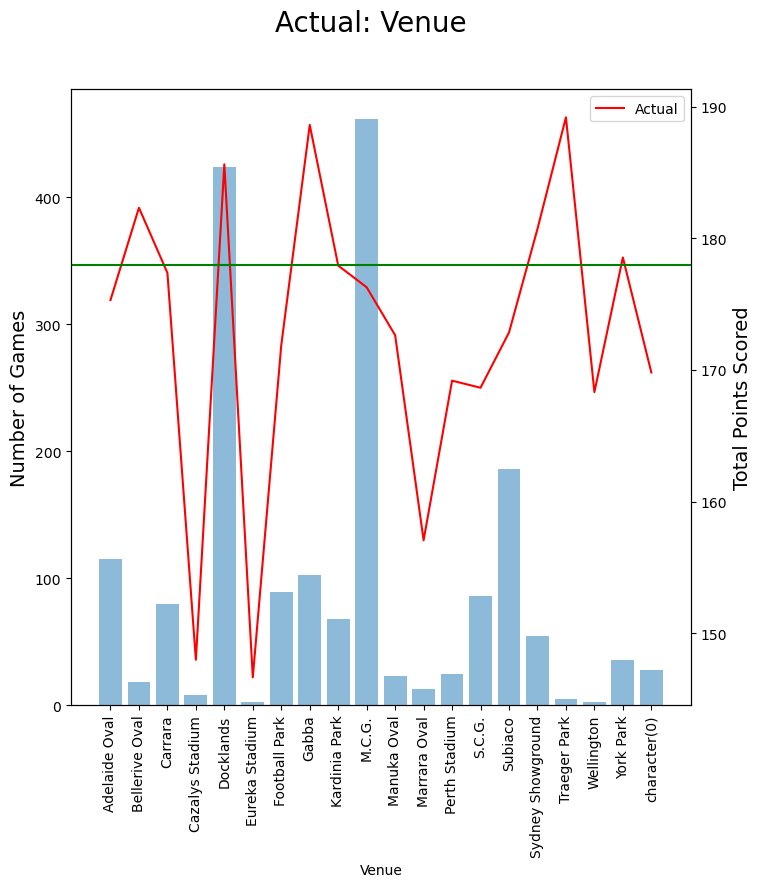

In [62]:
plot_feature(training_data, "Total Game Score", "Venue")

In [63]:
_get_feature_plot_data(training_data, "Total Game Score", "Venue")

,feature,actual,exposure,relative
0,Adelaide Oval,175.321739,115,0.985026
1,Bellerive Oval,182.333333,18,1.024420
2,Carrara,177.387500,80,0.996632
3,Cazalys Stadium,148.000000,8,0.831522
4,Docklands,185.634434,424,1.042967
5,Eureka Stadium,146.666667,3,0.824031
6,Football Park,171.898876,89,0.965795
7,Gabba,188.621359,103,1.059749
8,Kardinia Park,177.941176,68,0.999743
9,M.C.G.,176.292208,462,0.990479


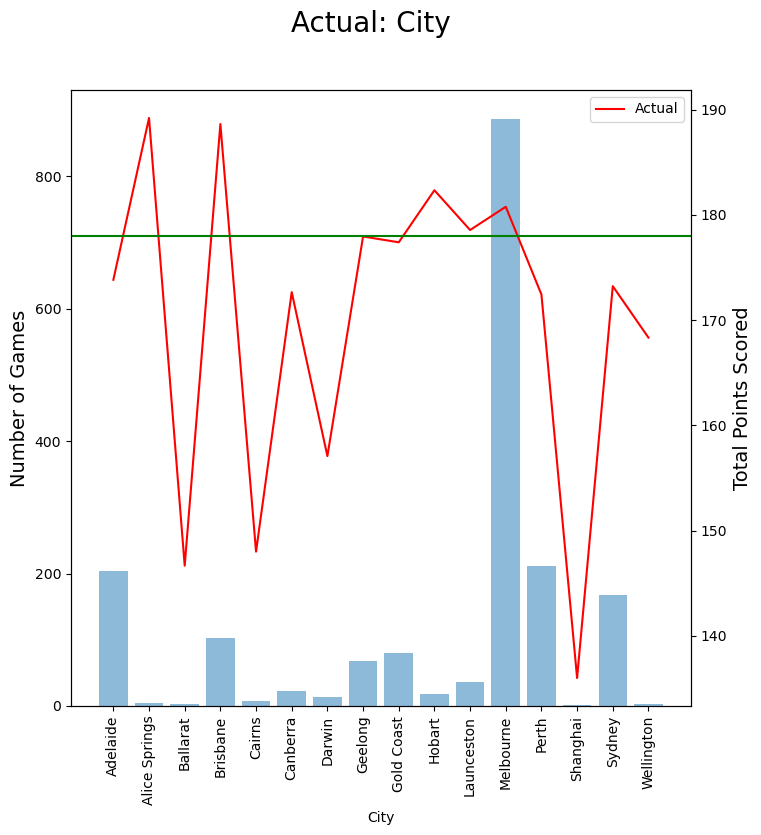

In [64]:
plot_feature(training_data, "Total Game Score", "City")

In [65]:
_get_feature_plot_data(training_data, "Total Game Score", "City")

,feature,actual,exposure,relative
0,Adelaide,173.828431,204,0.976636
1,Alice Springs,189.200000,5,1.063000
2,Ballarat,146.666667,3,0.824031
3,Brisbane,188.621359,103,1.059749
4,Cairns,148.000000,8,0.831522
5,Canberra,172.652174,23,0.970028
6,Darwin,157.076923,13,0.882520
7,Geelong,177.941176,68,0.999743
8,Gold Coast,177.387500,80,0.996632
9,Hobart,182.333333,18,1.024420


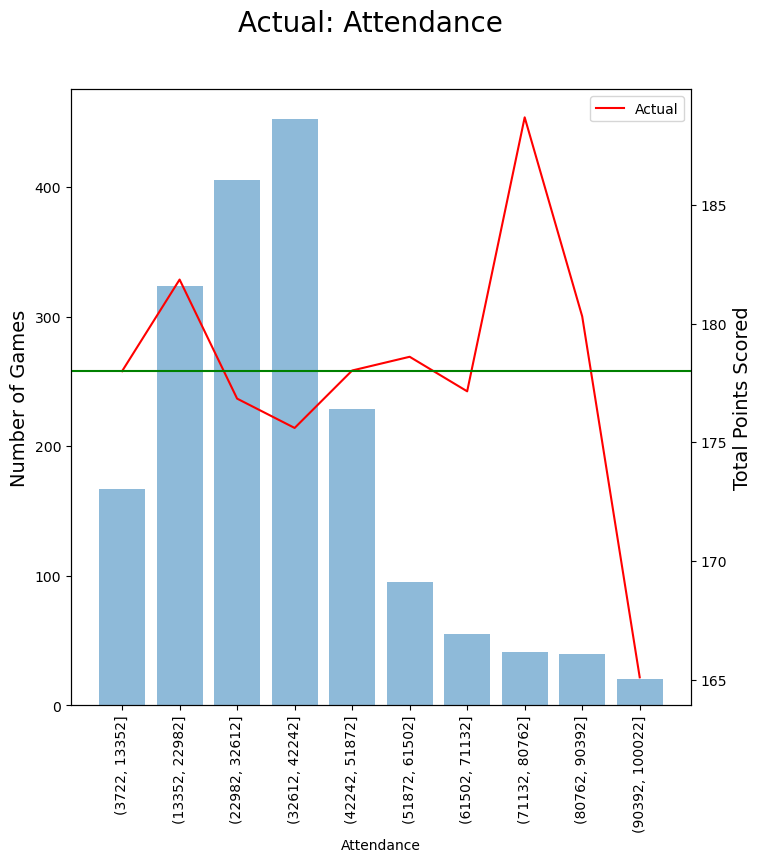

In [66]:
plot_feature(training_data, "Total Game Score", "Attendance")

In [67]:
_get_feature_plot_data(training_data, "Total Game Score", "Attendance")

,feature,actual,exposure,relative
0,"(3722, 13352]",177.994012,167,1.000040
1,"(13352, 22982]",181.851852,324,1.021715
2,"(22982, 32612]",176.837438,406,0.993542
3,"(32612, 42242]",175.602649,453,0.986604
4,"(42242, 51872]",178.021834,229,1.000196
5,"(51872, 61502]",178.600000,95,1.003445
6,"(61502, 71132]",177.145455,55,0.995273
7,"(71132, 80762]",188.682927,41,1.060095
8,"(80762, 90392]",180.300000,40,1.012996
9,"(90392, 100022]",165.100000,20,0.927596


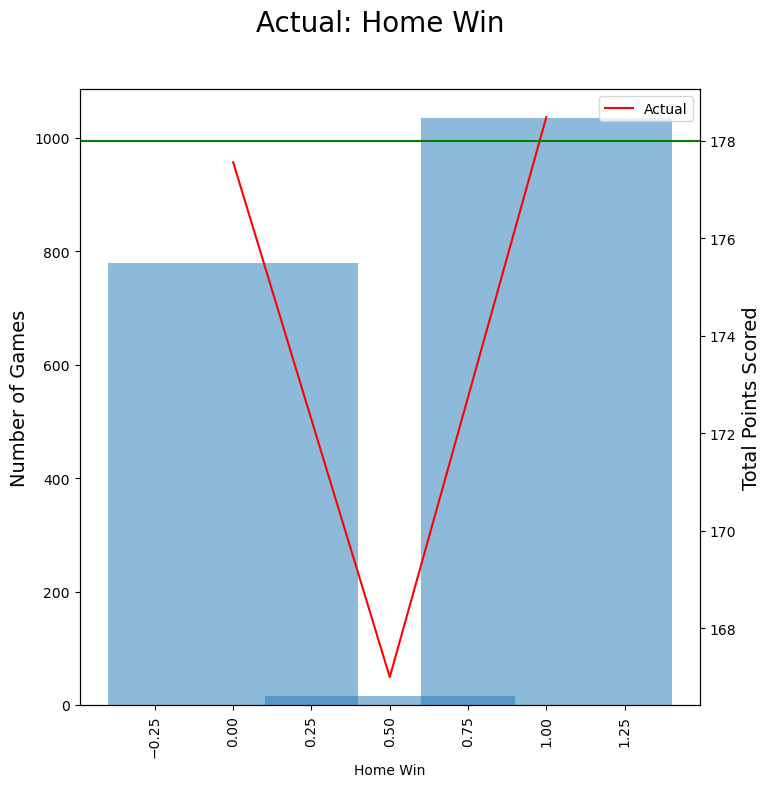

In [68]:
plot_feature(training_data, "Total Game Score", "Home Win")

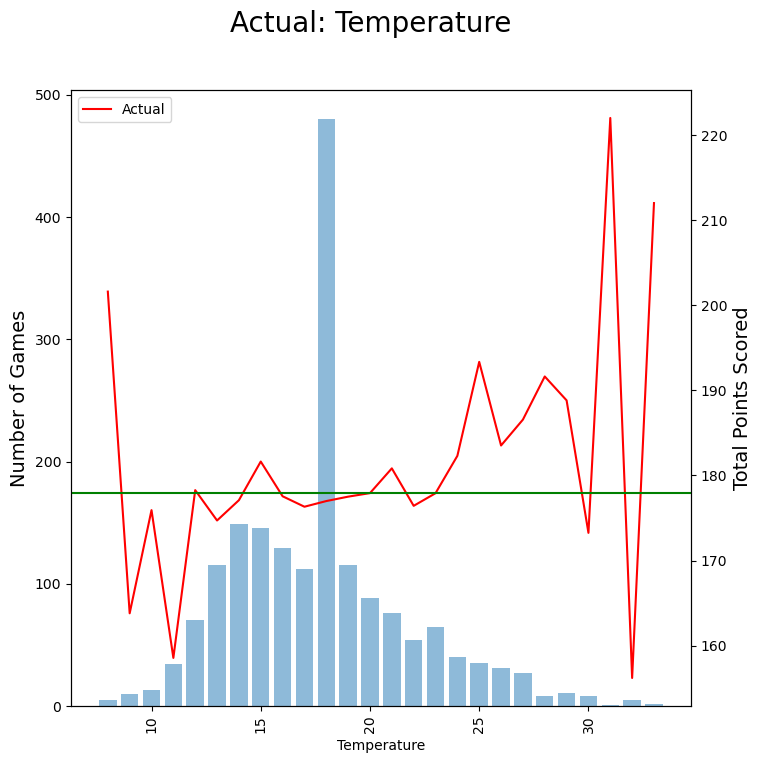

In [69]:
plot_feature(training_data, "Total Game Score", "Temperature")

In [70]:
training_data['Weather_Type'].value_counts(dropna=False)

MOSTLY_SUNNY     698
OVERCAST         463
RAIN             278
MOSTLY_CLEAR     116
CLEAR_NIGHT      114
SUNNY            112
ROOF_CLOSED       19
WINDY             14
THUNDERSTORMS      8
WINDY_RAIN         7
NaN                1
Name: Weather_Type, dtype: int64

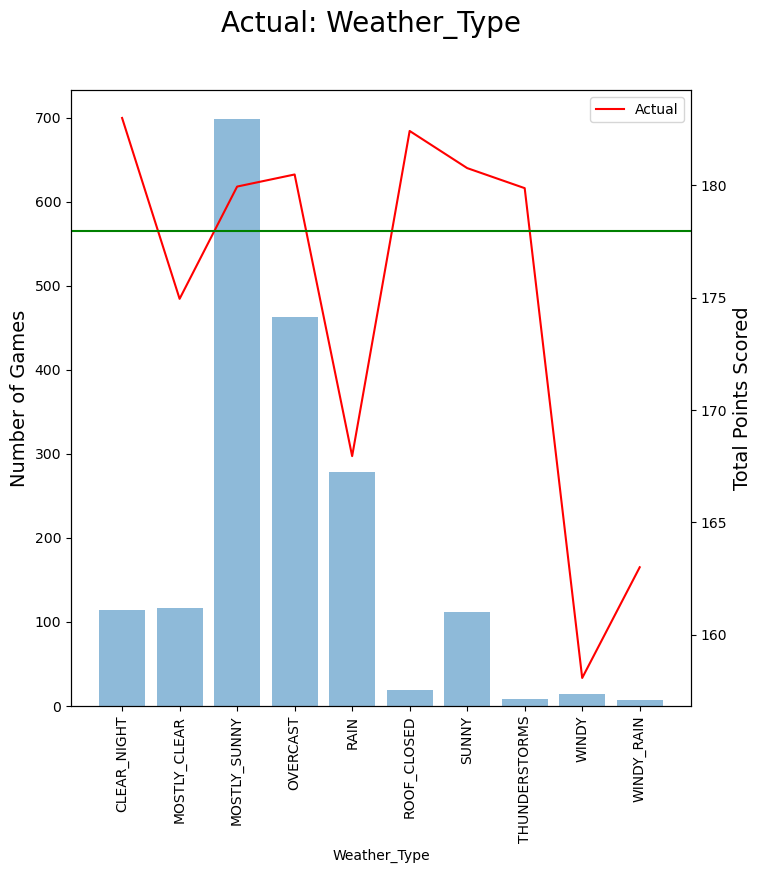

In [71]:
plot_feature(training_data[~training_data['Weather_Type'].isnull()], "Total Game Score", "Weather_Type")

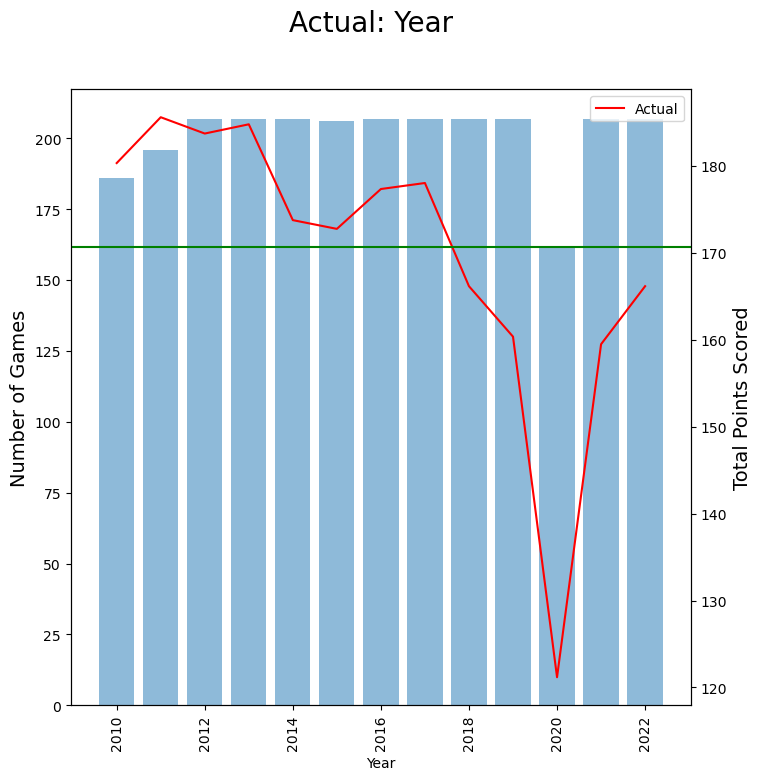

In [72]:
plot_feature(afl_data, "Total Game Score", "Year")

Round ID

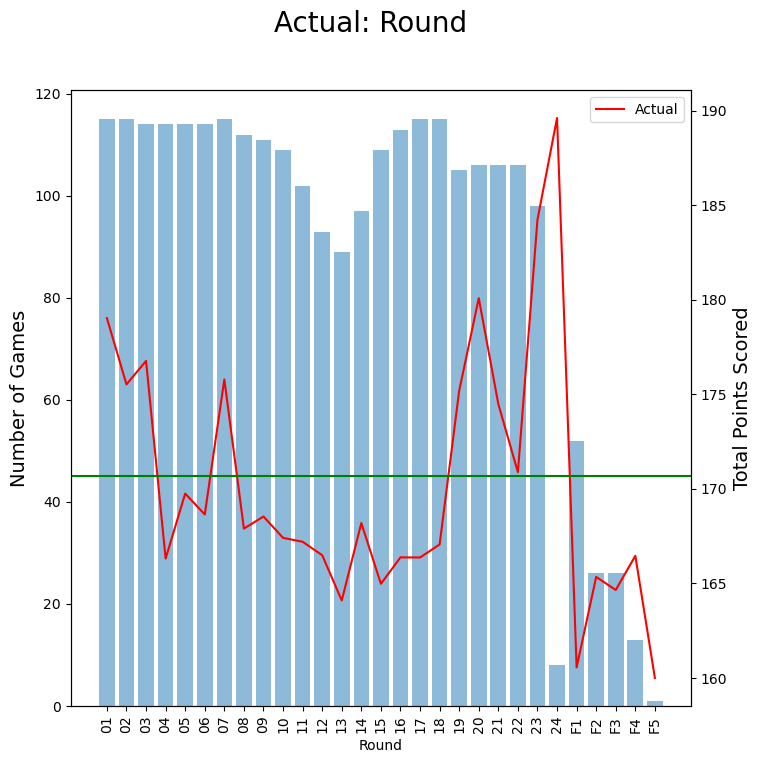

In [73]:
plot_feature(afl_data, "Total Game Score", "Round")

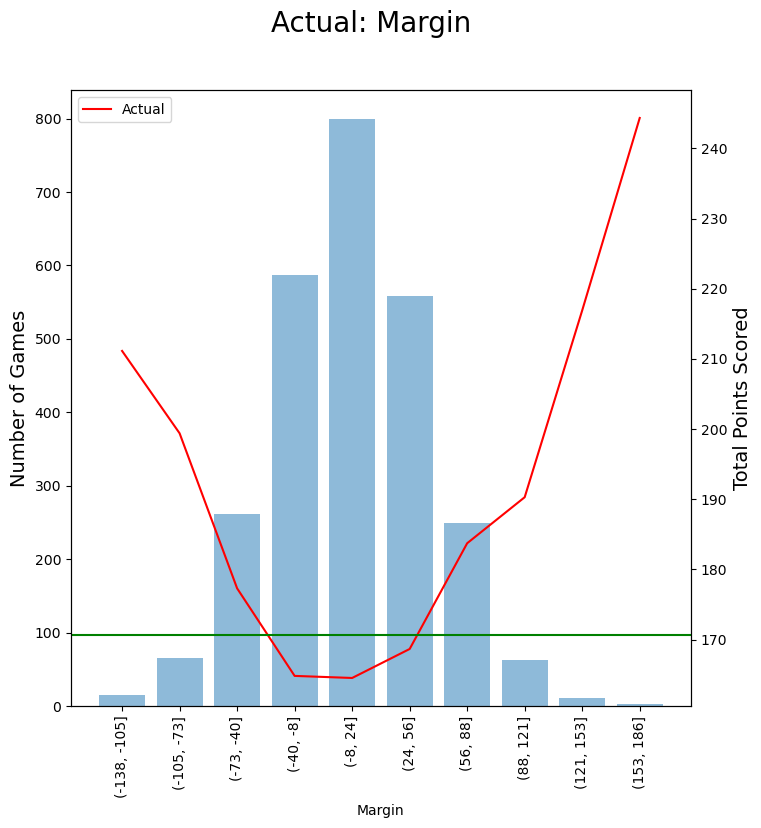

In [85]:
plot_feature(afl_data, "Total Game Score", "Margin")

Scoring

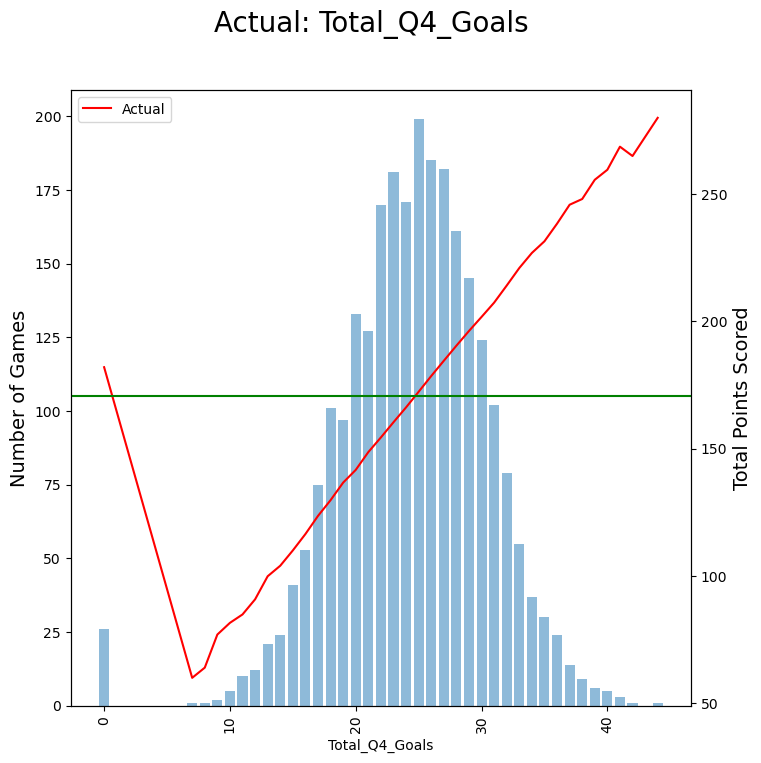

In [76]:
plot_feature(afl_data, "Total Game Score", "Total_Q4_Goals")

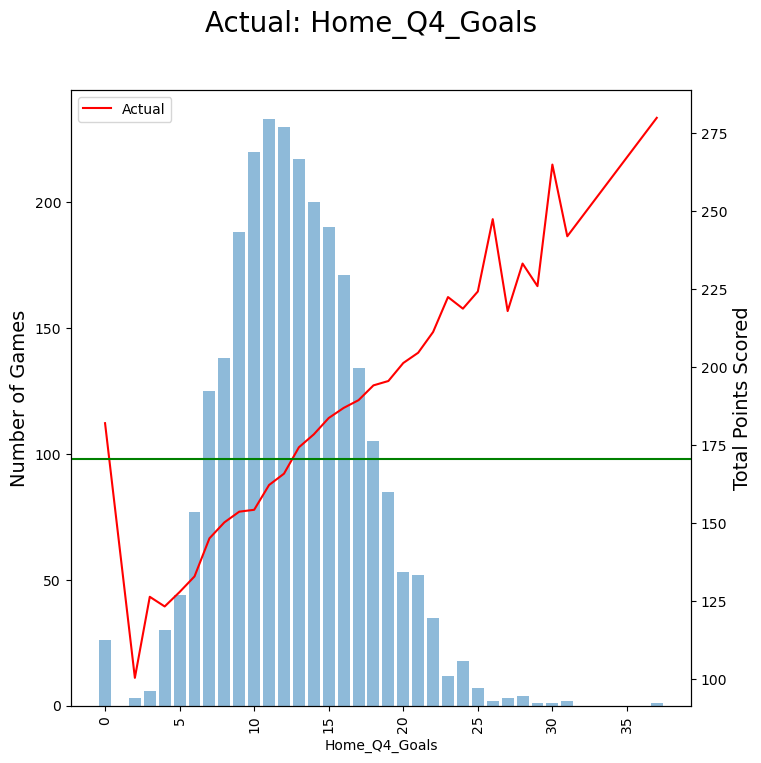

In [83]:
plot_feature(afl_data, "Total Game Score", "Home_Q4_Goals")

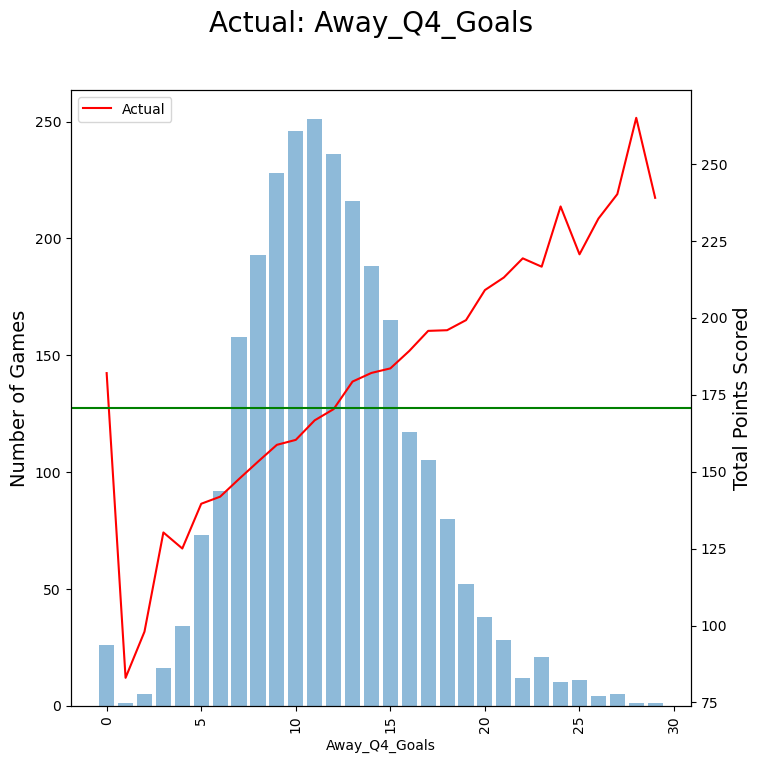

In [84]:
plot_feature(afl_data, "Total Game Score", "Away_Q4_Goals")

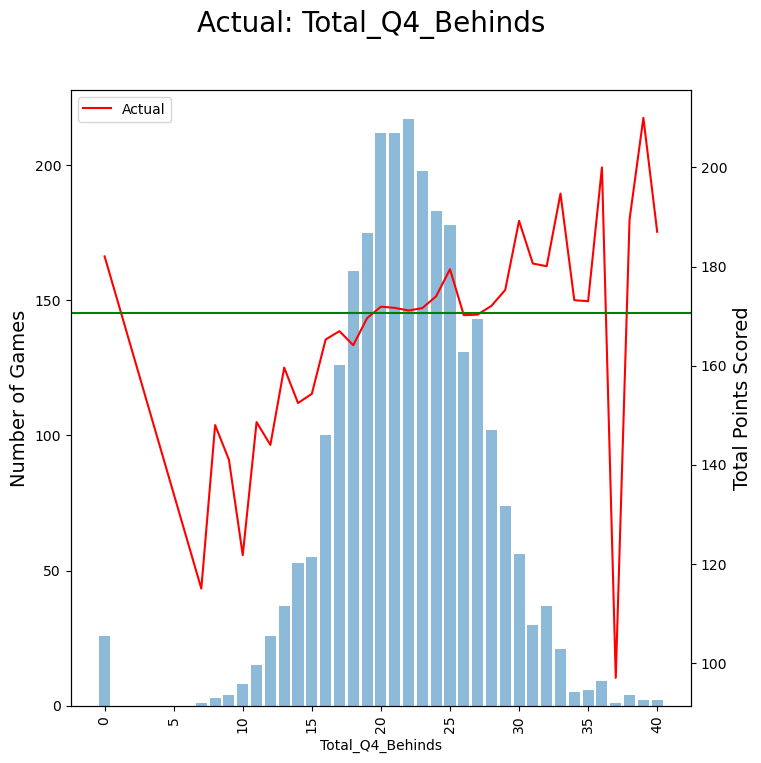

In [78]:
plot_feature(afl_data, "Total Game Score", "Total_Q4_Behinds")

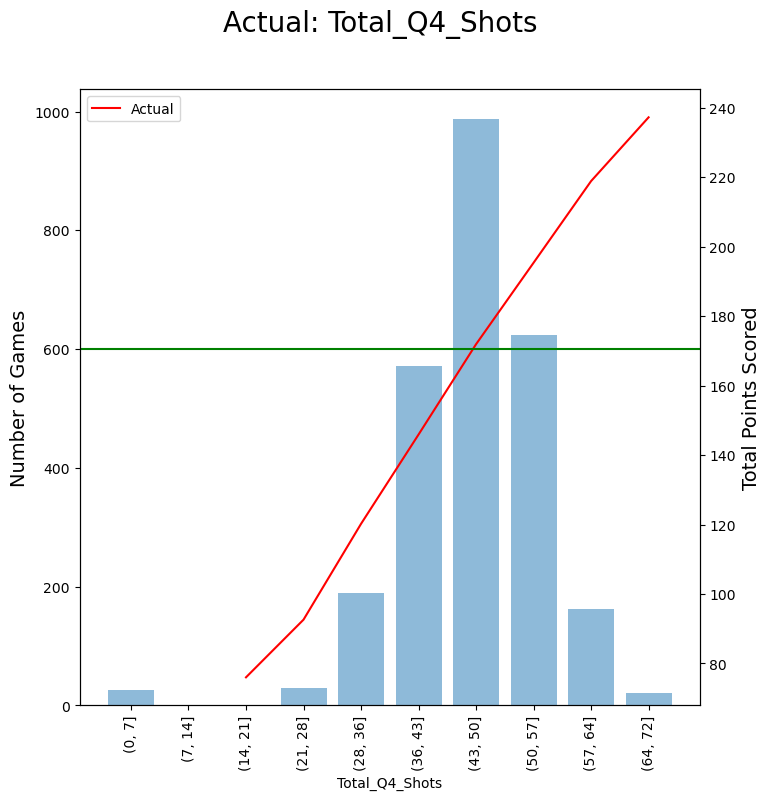

In [77]:
plot_feature(afl_data, "Total Game Score", "Total_Q4_Shots")